# The idea is to bin weekly % gains into >=5% (1) or <5% (0), then predict the outcome with binary classification.  This gives percent confidence in a prediction as well.
Uses code from prototype_large_feature_target_creation_3-2018.ipynb

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import sys
sys.path.append('../code')
import data_processing as dp

from concurrent.futures import ProcessPoolExecutor

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.6/dist-packages/odo/backends/pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [3]:
sorted_old = pd.read_csv('old_good_sorted_by_ewm.csv')

In [4]:
sorted_old.head()

,Unnamed: 0,ewm_vols,mean_vol,ticker
0,4,0.019357,0.017844,GGP
1,0,0.018310,0.021799,LNG
2,11,0.017963,0.016503,AKS
3,10,0.016127,0.016546,CHK
4,15,0.016113,0.016187,AMD


In [5]:
sorted_old.shape

(391, 4)

In [6]:
top_stocks = sorted_old.loc[:, 'ticker'].tolist() + ['SPY', 'UPRO', 'QQQ', 'TQQQ', 'DIA', 'UBT']

In [7]:
dfs, _, _ = dp.load_stocks(stocks=top_stocks,
                           finra_shorts=False,
                           short_interest=False,
                           earliest_date=None,
                           calc_scores=False)

loading stocks...
calculating TAs...


In [8]:
def get_latest_earliest_date(dfs, verbose=False):
    earliest_dates = []
    for s in dfs.keys():
        earliest_date = dfs[s].index.min()
        if verbose:
            print(s, earliest_date)
            
        earliest_dates.append(earliest_date)
    
    return max(earliest_dates), earliest_dates

In [10]:
_, earliest_dates = get_latest_earliest_date(dfs)

In [11]:
len(earliest_dates)

394

In [12]:
len(top_stocks)

397

In [13]:
earliest_dates_df = pd.DataFrame({'earliest_date': earliest_dates, 'ticker': list(dfs.keys())})

In [14]:
earliest_dates_df.sort_values(by='earliest_date', inplace=True)

In [15]:
earliest_dates_df.iloc[0]['earliest_date']

Timestamp('1962-01-02 00:00:00')

In [16]:
earliest_dates_df.head()

,earliest_date,ticker
194,1962-01-02,BA
201,1962-01-02,CAT
323,1962-01-02,IBM
256,1962-01-02,GE
119,1962-01-02,HPQ


In [17]:
earliest_dates_df[earliest_dates_df['earliest_date'] <= pd.to_datetime('1-1-1971')]

,earliest_date,ticker
194,1962-01-02,BA
201,1962-01-02,CAT
323,1962-01-02,IBM
256,1962-01-02,GE
119,1962-01-02,HPQ
356,1962-01-02,KO
213,1962-01-02,DIS
368,1970-01-02,PG
369,1970-01-02,AEP
322,1970-01-02,MCD


In [18]:
earliest_stocks = earliest_dates_df[earliest_dates_df['earliest_date'] <= pd.to_datetime('1-1-1971')]['ticker'].values

In [19]:
earliest_stocks

array(['BA', 'CAT', 'IBM', 'GE', 'HPQ', 'KO', 'DIS', 'PG', 'AEP', 'MCD',
       'MRO', 'CVX', 'JNJ', 'IP', 'DTE', 'HON', 'ED', 'MRK', 'MMM', 'XOM',
       'UTX', 'FL', 'MO'], dtype=object)

In [20]:
earliest_dfs = {s: dfs[s] for s in dfs.keys() if s in earliest_stocks}

In [21]:
latest_date, _ = get_latest_earliest_date(earliest_dfs)

In [22]:
latest_date

Timestamp('1970-01-02 00:00:00')

In [23]:
for s in earliest_dfs.keys():
    # standardize to latest date so they all have the same earliest time
    earliest_dfs[s] = earliest_dfs[s][earliest_dfs[s].index > latest_date]

In [200]:
def make_ohlcv_feats_targs_one(s, df, past_cols, fut_cols, past_periods, future_days, threshold=0.05, verbose=False):
    if verbose:
        print(s)
        
    epsilon = 0.001
    past_pct_change_dict = {}
    fut_pct_change_dict = {}
    for c in past_cols:
        for p in past_periods:
            past_pct_change_dict[c + '_pct_change_p=' + str(p)] = []

    for c in fut_cols:
        for f in future_days:
            fut_pct_change_dict[c + '_pct_change_f=' + str(f) + '_gt_' + str(threshold)] = []
            fut_pct_change_dict[c + '_pct_change_f=' + str(f) + '_lt_-' + str(threshold)] = []

    last_idx = df.shape[0] - 1
    for i, (index, r) in enumerate(df.iterrows()):
        # create time-lagged percent difference features for OHLCV (and maybe eventually TAs) not bound to a range
        for c in past_cols:
            for p in past_periods:
                if i >= p: # if on day 2 (index 1), then the lag would be current - 0
                    old = df[c].iloc[i-p] + epsilon
                    new = df[c].iloc[i]
                    pct_change = (new - old) / old
                    past_pct_change_dict[c + '_pct_change_p=' + str(p)].append(pct_change)
                else:
                    past_pct_change_dict[c + '_pct_change_p=' + str(p)].append(np.nan)
        # create future targets for each of future_days
        for c in fut_cols:
            for f in future_days:
                if i + f <= last_idx: # if on day 2 (index 1), then the lag would be current - 0
                    old = df[c].iloc[i] + epsilon
                    new = df[c].iloc[i + f]
                    pct_change = (new - old) / old
                    if pct_change >= threshold:
                        fut_pct_change_dict[c + '_pct_change_f=' + str(f) + '_gt_' + str(threshold)].append(1)
                    else:
                        fut_pct_change_dict[c + '_pct_change_f=' + str(f) + '_gt_' + str(threshold)].append(0)
                    if pct_change <= -threshold:
                        fut_pct_change_dict[c + '_pct_change_f=' + str(f) + '_lt_-' + str(threshold)].append(1)
                    else:
                        fut_pct_change_dict[c + '_pct_change_f=' + str(f) + '_lt_-' + str(threshold)].append(0)
                else:
                    fut_pct_change_dict[c + '_pct_change_f=' + str(f) + '_gt_' + str(threshold)].append(np.nan)
                    fut_pct_change_dict[c + '_pct_change_f=' + str(f) + '_lt_-' + str(threshold)].append(np.nan)

    # add to dataframe
    df = df.assign(**past_pct_change_dict)
    df = df.assign(**fut_pct_change_dict)
    df.drop(past_cols, inplace=True, axis=1)
    return df

In [201]:
def make_ohlcv_feats_targs_multithread(dfs,
                           past_periods=[1, 2, 3, 5, 10, 20, 30, 50, 100],
                           future_days=range(1, 11),
                           threshold=0.05,
                           verbose=True,
                           debug=False):
    # columns for past data creation
    past_cols = ['Adj_Open', 'Adj_Close', 'Adj_High', 'Adj_Low', 'Adj_Volume', 'typical_price']
    # columns used for future targets
    fut_cols = ['Adj_Close']
    
    if debug:
        for s in dfs.keys():
            if verbose:
                print(s)
            
            dfs[s] = make_ohlcv_feats_targs_one(dfs[s], past_cols, fut_cols, past_periods, future_days)
            
        return
    
    jobs = []
    with ProcessPoolExecutor(max_workers=None) as executor:
        for s in dfs.keys():
            r = executor.submit(make_ohlcv_feats_targs_one,
                                s,
                                dfs[s],
                                past_cols,
                                fut_cols,
                                past_periods,
                                future_days,
                                threshold,
                                verbose)
            jobs.append((s, r))

    for s, r in jobs:
        res = r.result()
        if res is not None:
            dfs[s] = res
        else:
                print('result is None for', s)

        # no need to return anything, all updates made in-place

In [26]:
def drop_cols(dfs):
    # find TAS not bound to range -- from EDA short data 1-2-2018.ipynb file

    # columns to ignore because they have large outliers that can't really be ignored
    ignore_cols = set(['Open',
                        'Close',
                        'Low', 
                        'High',
                        'Volume',
                        'Dividend',
                        'Split',
                        'bband_u_cl',
                        'bband_m_cl',
                        'bband_l_cl',
                        'bband_u_tp',
                        'bband_m_tp',
                        'bband_l_tp',
                        'dema_cl',
                        'dema_tp',
                        'ema_cl',
                        'ema_tp',
                        'ht_tl_cl',
                        'ht_tl_tp',
                        'kama_cl',
                        'kama_tp',
                        'mavp_cl',
                        'mavp_tp',
                        'midp_cl',
                        'midp_tp',
                        'midpr',
                        'sar',
                        'sma_10_cl',
                        'sma_10_tp',
                        'sma_20_cl',
                        'sma_20_tp',
                        'sma_30_cl',
                        'sma_30_tp',
                        'sma_40_cl',
                        'sma_40_tp',
                        'tema_cl',
                        'tema_tp',
                        'trima_cl',
                        'trima_tp',
                        'wma_cl',
                        'wma_tp',
                        'mdm',
                        'pldm',
                        'rocr_cl_100', # already have the same data /100 as rocr
                        'rocr_tp_100',
                        'atr',
                        'natr',
                        'trange',
                        'Shares_Float',
                        'Shares_Outstanding',
                        'Avg._Daily_Vol.',
                        'Ticker'])

    first = list(dfs.keys())[0]
    keep_cols = [c for c in dfs[first].columns.tolist() if c not in ignore_cols]
    for s in dfs.keys():
        dfs[s] = dfs[s][keep_cols]

In [27]:
drop_cols(earliest_dfs)

In [28]:
earliest_dfs['FL'].head()

,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,typical_price,bband_u_cl_diff,bband_m_cl_diff,bband_l_cl_diff,bband_u_cl_diff_hi,...,ht_ph_cl,ht_ph_tp,ht_q_cl,ht_q_tp,ht_s_cl,ht_s_tp,ht_ls_cl,ht_ls_tp,ht_tr_cl,ht_tr_tp
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-05,1.794257,1.823809,1.776900,1.776900,32800.0,38.213333,1.363667,0.35,-0.663667,1.113667,...,-0.768839,-0.666338,-0.508365,-0.734924,0.982634,0.972172,0.826035,0.853082,0,0
1970-01-06,1.771289,1.776900,1.759131,1.776900,48400.0,37.873333,1.363667,0.35,-0.663667,1.113667,...,-0.768839,-0.666338,-0.508365,-0.734924,0.982634,0.972172,0.826035,0.853082,0,0
1970-01-07,1.772760,1.772760,1.749280,1.749280,31200.0,37.416667,1.363667,0.35,-0.663667,1.113667,...,-0.768839,-0.666338,-0.508365,-0.734924,0.982634,0.972172,0.826035,0.853082,0,0
1970-01-08,1.746764,1.770210,1.735040,1.758487,40400.0,37.416667,1.363667,0.35,-0.663667,1.113667,...,-0.768839,-0.666338,-0.508365,-0.734924,0.982634,0.972172,0.826035,0.853082,0,0
1970-01-09,1.748643,1.748643,1.730867,1.730867,35600.0,37.126667,1.363667,0.35,-0.663667,1.113667,...,-0.768839,-0.666338,-0.508365,-0.734924,0.982634,0.972172,0.826035,0.853082,0,0


In [29]:
make_ohlcv_feats_targs_multithread(earliest_dfs)

FL
HPQ
MRO
IP
BA
CAT
DIS
HON
GE
UTX
MRK
CVX
MCD
IBM
MO
XOM
MMM
KO
JNJ
PG
AEP
DTE
ED


In [30]:
s = 'FL'

In [83]:
targ_cols = [c for c in earliest_dfs[s].columns if 'f=' in c]
feat_cols = [c for c in earliest_dfs[s].columns if c not in set(targ_cols)]

no_missing = earliest_dfs[s].dropna()
s_features = no_missing[feat_cols]

feat_labels = []
targ_labels = []
feat_labels.extend([s + '_' + c for c in s_features.columns.tolist()])
s_targets = no_missing[targ_cols]
targ_labels.extend([s + '_' + c for c in s_targets.columns.tolist()])
features = s_features.values

targets = s_targets.values
# only use 5 days in future as target
#targets = s_targets.values[:, 4].reshape(-1, 1)

train_frac = 0.8
train_size = int(features.shape[0] * train_frac)
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

In [84]:
train_features.shape

(9642, 147)

In [85]:
train_targets.shape

(9642, 10)

In [86]:
targ_labels

['FL_Adj_Close_pct_change_f=1_gt_0.05',
 'FL_Adj_Close_pct_change_f=2_gt_0.05',
 'FL_Adj_Close_pct_change_f=3_gt_0.05',
 'FL_Adj_Close_pct_change_f=4_gt_0.05',
 'FL_Adj_Close_pct_change_f=5_gt_0.05',
 'FL_Adj_Close_pct_change_f=6_gt_0.05',
 'FL_Adj_Close_pct_change_f=7_gt_0.05',
 'FL_Adj_Close_pct_change_f=8_gt_0.05',
 'FL_Adj_Close_pct_change_f=9_gt_0.05',
 'FL_Adj_Close_pct_change_f=10_gt_0.05']

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

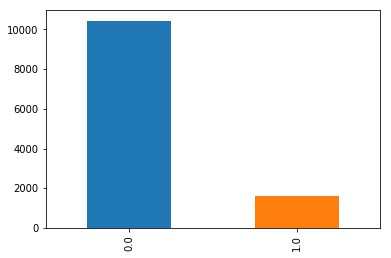

In [107]:
pd.value_counts(targets[:, 4]).plot.bar()
# pd.value_counts(targets[:, 0]).plot.bar()

In [108]:
pd.value_counts(targets[:, 4])
# pd.value_counts(targets[:, 0])

0.0    10433
1.0     1620
dtype: int64

In [109]:
# no information rate -- always guess 0 -- need to beat this accuracy
pd.value_counts(targets[:, 4])[0] / pd.value_counts(targets[:, 4]).sum()
# pd.value_counts(targets[:, 0])[0] / pd.value_counts(targets[:, 0]).sum()

0.8655936281423712

In [91]:
from keras.layers import Input, Dense, Dropout, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Activation, Flatten, Concatenate, Reshape
from keras.models import Model, load_model
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.regularizers import l1_l2
import keras.backend as K
import keras.losses

In [92]:
train_features.shape

(9642, 147)

In [99]:
K.clear_session()

timesteps = 1
input_dim = train_features.shape[1]
output_dim = train_targets.shape[1]

inputs = Input(shape=(timesteps*input_dim, ))
x = BatchNormalization()(inputs)
x = Dense(3000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(2000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(500, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(100, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(output_dim, activation='sigmoid')(x)

mod = Model(inputs, x)
mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [100]:
es = EarlyStopping(monitor='val_loss', patience=10)

history = mod.fit(train_features,
            train_targets,
            epochs=300,
            validation_split=0.1,
            batch_size=2000,
            callbacks=[es])

Train on 8677 samples, validate on 965 samples
Epoch 1/300
8677/8677 [==============================] - 1s 87us/step - loss: 0.8889 - acc: 0.5240 - val_loss: 1.0708 - val_acc: 0.4255
Epoch 2/300
8677/8677 [==============================] - 0s 23us/step - loss: 0.7016 - acc: 0.5528 - val_loss: 0.9324 - val_acc: 0.3542
Epoch 3/300
8677/8677 [==============================] - 0s 22us/step - loss: 0.6796 - acc: 0.5869 - val_loss: 0.9224 - val_acc: 0.3372
Epoch 4/300
8677/8677 [==============================] - 0s 23us/step - loss: 0.6660 - acc: 0.6278 - val_loss: 0.9065 - val_acc: 0.3226
Epoch 5/300
8677/8677 [==============================] - 0s 22us/step - loss: 0.6548 - acc: 0.6630 - val_loss: 0.8503 - val_acc: 0.3426
Epoch 6/300
8677/8677 [==============================] - 0s 22us/step - loss: 0.6440 - acc: 0.6852 - val_loss: 0.8157 - val_acc: 0.3869
Epoch 7/300
8677/8677 [==============================] - 0s 22us/step - loss: 0.6336 - acc: 0.7096 - val_loss: 0.7636 - val_acc: 0.4598
E

Text(0,0.5,'val loss')

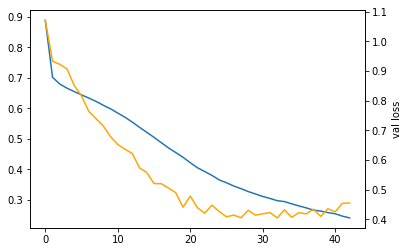

In [101]:
fig, ax1 = plt.subplots()
_ = ax1.plot(history.history['loss'])
ax2 = ax1.twinx()
_ = ax2.plot(history.history['val_loss'], c='orange')
ax2.set_ylabel('val loss')

Text(0,0.5,'val accuracy')

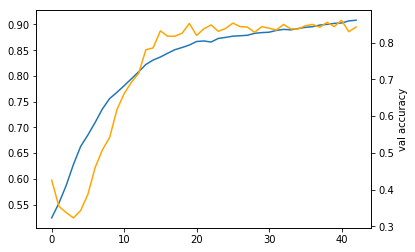

In [102]:
fig, ax1 = plt.subplots()
_ = ax1.plot(history.history['acc'])
ax2 = ax1.twinx()
_ = ax2.plot(history.history['val_acc'], c='orange')
ax2.set_ylabel('val accuracy')

In [103]:
mod.evaluate(train_features, train_targets)

9642/9642 [==============================] - 1s 79us/step


[0.2492317281751508, 0.9023957695488216]

In [104]:
mod.evaluate(test_features, test_targets)

2411/2411 [==============================] - 0s 79us/step


[0.5575952847089969, 0.8357113214114651]

In [105]:
val_size = int(0.1 * train_targets.shape[0])
mod.evaluate(train_features[:-val_size], train_targets[:-val_size])

8678/8678 [==============================] - 1s 78us/step


[0.2263802840263012, 0.9090458634098051]

In [106]:
mod.evaluate(train_features[-val_size:], train_targets[-val_size:])

964/964 [==============================] - 0s 76us/step


[0.45494214103738795, 0.8425311270591135]

# Shrink net to prevent overfitting

In [110]:
K.clear_session()

timesteps = 1
input_dim = train_features.shape[1]
output_dim = train_targets.shape[1]

inputs = Input(shape=(timesteps*input_dim, ))
x = BatchNormalization()(inputs)
x = Dense(1000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(500, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(100, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(output_dim, activation='sigmoid')(x)

mod = Model(inputs, x)
mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [127]:
mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 147)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 147)               588       
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              148000    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
batch_normalization_3 (Batch (None, 500)               2000      
__________

In [111]:
es = EarlyStopping(monitor='val_loss', patience=10)

history = mod.fit(train_features,
            train_targets,
            epochs=300,
            validation_split=0.1,
            batch_size=2000,
            callbacks=[es])

Train on 8677 samples, validate on 965 samples
Epoch 1/300
8677/8677 [==============================] - 1s 58us/step - loss: 0.8402 - acc: 0.5041 - val_loss: 0.8254 - val_acc: 0.3679
Epoch 2/300
8677/8677 [==============================] - 0s 8us/step - loss: 0.7495 - acc: 0.5335 - val_loss: 0.7793 - val_acc: 0.3969
Epoch 3/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.7109 - acc: 0.5583 - val_loss: 0.7460 - val_acc: 0.4428
Epoch 4/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.6860 - acc: 0.5893 - val_loss: 0.7377 - val_acc: 0.4426
Epoch 5/300
8677/8677 [==============================] - 0s 8us/step - loss: 0.6716 - acc: 0.6132 - val_loss: 0.7335 - val_acc: 0.4591
Epoch 6/300
8677/8677 [==============================] - 0s 10us/step - loss: 0.6583 - acc: 0.6415 - val_loss: 0.7226 - val_acc: 0.4825
Epoch 7/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.6458 - acc: 0.6718 - val_loss: 0.7131 - val_acc: 0.5030
Epoch 

Text(0,0.5,'val accuracy')

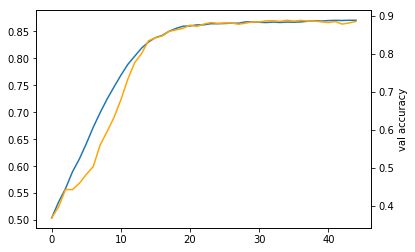

In [112]:
fig, ax1 = plt.subplots()
_ = ax1.plot(history.history['acc'])
ax2 = ax1.twinx()
_ = ax2.plot(history.history['val_acc'], c='orange')
ax2.set_ylabel('val accuracy')

# Went a bit too small, try adding a few layers at the end

In [116]:
K.clear_session()

timesteps = 1
input_dim = train_features.shape[1]
output_dim = train_targets.shape[1]

inputs = Input(shape=(timesteps*input_dim, ))
x = BatchNormalization()(inputs)
x = Dense(1000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(500, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(100, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(output_dim, activation='sigmoid')(x)

mod = Model(inputs, x)
mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [117]:
es = EarlyStopping(monitor='val_loss', patience=10)

history = mod.fit(train_features,
            train_targets,
            epochs=300,
            validation_split=0.1,
            batch_size=2000,
            callbacks=[es])

Train on 8677 samples, validate on 965 samples
Epoch 1/300
8677/8677 [==============================] - 1s 66us/step - loss: 0.7937 - acc: 0.5063 - val_loss: 0.8285 - val_acc: 0.3916
Epoch 2/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.7477 - acc: 0.5192 - val_loss: 0.8434 - val_acc: 0.4180
Epoch 3/300
8677/8677 [==============================] - 0s 10us/step - loss: 0.7269 - acc: 0.5299 - val_loss: 0.8104 - val_acc: 0.4279
Epoch 4/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.7150 - acc: 0.5451 - val_loss: 0.7841 - val_acc: 0.4309
Epoch 5/300
8677/8677 [==============================] - 0s 10us/step - loss: 0.7058 - acc: 0.5562 - val_loss: 0.7756 - val_acc: 0.4250
Epoch 6/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.6974 - acc: 0.5672 - val_loss: 0.7684 - val_acc: 0.4204
Epoch 7/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.6907 - acc: 0.5763 - val_loss: 0.7645 - val_acc: 0.4148
Epoch

Epoch 61/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.3895 - acc: 0.8651 - val_loss: 0.4268 - val_acc: 0.8611
Epoch 62/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.3865 - acc: 0.8648 - val_loss: 0.4128 - val_acc: 0.8683
Epoch 63/300
8677/8677 [==============================] - 0s 8us/step - loss: 0.3846 - acc: 0.8643 - val_loss: 0.4097 - val_acc: 0.8710
Epoch 64/300
8677/8677 [==============================] - 0s 8us/step - loss: 0.3800 - acc: 0.8653 - val_loss: 0.4263 - val_acc: 0.8587
Epoch 65/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.3782 - acc: 0.8649 - val_loss: 0.4060 - val_acc: 0.8704
Epoch 66/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.3731 - acc: 0.8667 - val_loss: 0.4046 - val_acc: 0.8719
Epoch 67/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.3729 - acc: 0.8665 - val_loss: 0.3944 - val_acc: 0.8779
Epoch 68/300
8677/8677 [========================

Text(0,0.5,'val accuracy')

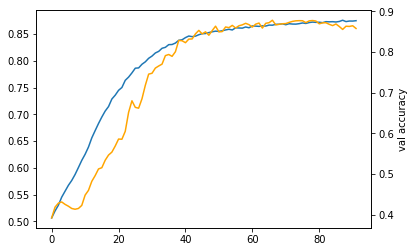

In [118]:
fig, ax1 = plt.subplots()
_ = ax1.plot(history.history['acc'])
ax2 = ax1.twinx()
_ = ax2.plot(history.history['val_acc'], c='orange')
ax2.set_ylabel('val accuracy')

# try halfway between input (about 150) and output (about 10) dimensions

In [137]:
K.clear_session()

timesteps = 1
input_dim = train_features.shape[1]
output_dim = train_targets.shape[1]

inputs = Input(shape=(timesteps*input_dim, ))
x = BatchNormalization()(inputs)
x = Dense(500, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(100, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(output_dim, activation='sigmoid')(x)

mod = Model(inputs, x)
mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [138]:
es = EarlyStopping(monitor='val_loss', patience=10)

history = mod.fit(train_features,
            train_targets,
            epochs=300,
            validation_split=0.1,
            batch_size=2000,
            callbacks=[es])

Train on 8677 samples, validate on 965 samples
Epoch 1/300
8677/8677 [==============================] - 1s 98us/step - loss: 0.8038 - acc: 0.4971 - val_loss: 0.7767 - val_acc: 0.4307
Epoch 2/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.7506 - acc: 0.5010 - val_loss: 0.7611 - val_acc: 0.4395
Epoch 3/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.7222 - acc: 0.5101 - val_loss: 0.7593 - val_acc: 0.4451
Epoch 4/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.7063 - acc: 0.5230 - val_loss: 0.7533 - val_acc: 0.4505
Epoch 5/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.6977 - acc: 0.5361 - val_loss: 0.7456 - val_acc: 0.4461
Epoch 6/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.6888 - acc: 0.5519 - val_loss: 0.7384 - val_acc: 0.4493
Epoch 7/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.6827 - acc: 0.5640 - val_loss: 0.7363 - val_acc: 0.4432
Epoch 8

Epoch 61/300
8677/8677 [==============================] - 0s 8us/step - loss: 0.3501 - acc: 0.8677 - val_loss: 0.3628 - val_acc: 0.8805
Epoch 62/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.3482 - acc: 0.8686 - val_loss: 0.3593 - val_acc: 0.8837
Epoch 63/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.3478 - acc: 0.8694 - val_loss: 0.3659 - val_acc: 0.8823
Epoch 64/300
8677/8677 [==============================] - 0s 8us/step - loss: 0.3458 - acc: 0.8708 - val_loss: 0.3654 - val_acc: 0.8804
Epoch 65/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.3450 - acc: 0.8684 - val_loss: 0.3591 - val_acc: 0.8812
Epoch 66/300
8677/8677 [==============================] - 0s 8us/step - loss: 0.3436 - acc: 0.8702 - val_loss: 0.3619 - val_acc: 0.8791
Epoch 67/300
8677/8677 [==============================] - 0s 9us/step - loss: 0.3418 - acc: 0.8702 - val_loss: 0.3649 - val_acc: 0.8777
Epoch 68/300
8677/8677 [========================

Text(0,0.5,'val accuracy')

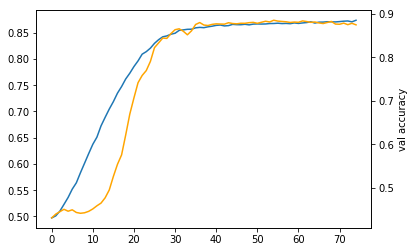

In [139]:
fig, ax1 = plt.subplots()
_ = ax1.plot(history.history['acc'])
ax2 = ax1.twinx()
_ = ax2.plot(history.history['val_acc'], c='orange')
ax2.set_ylabel('val accuracy')

# combine data from oldest stocks into giant feature/training set -- use all stocks' features as features

In [141]:
feat_labels = []
targ_labels = []
features = None
for s in earliest_dfs.keys():
    targ_cols = [c for c in earliest_dfs[s].columns if 'f=' in c]
    feat_cols = [c for c in earliest_dfs[s].columns if c not in set(targ_cols)]
    no_missing = earliest_dfs[s].dropna()
    s_features = no_missing[feat_cols]
    feat_labels.extend([s + '_' + c for c in s_features.columns.tolist()])
    s_targets = no_missing[targ_cols]
    targ_labels.extend([s + '_' + c for c in s_targets.columns.tolist()])
    if features is None:
        features = s_features.values
        targets = s_targets.values
    else:
        features = np.hstack((features, s_features))
        targets = np.hstack((targets, s_targets))

train_size = int(features.shape[0] * train_frac)
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

In [142]:
features.shape

(12053, 3381)

In [143]:
targets.shape

(12053, 230)

In [144]:
K.clear_session()

timesteps = 1
input_dim = train_features.shape[1]
output_dim = train_targets.shape[1]

inputs = Input(shape=(timesteps*input_dim, ))
x = BatchNormalization()(inputs)
x = Dense(3000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(2000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(500, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(100, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(output_dim, activation='sigmoid')(x)

mod = Model(inputs, x)
mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [145]:
es = EarlyStopping(monitor='val_loss', patience=10)

history = mod.fit(train_features,
            train_targets,
            epochs=300,
            validation_split=0.1,
            batch_size=2000,
            callbacks=[es])

Train on 8677 samples, validate on 965 samples
Epoch 1/300
8677/8677 [==============================] - 1s 172us/step - loss: 0.7410 - acc: 0.5100 - val_loss: 0.8408 - val_acc: 0.4986
Epoch 2/300
8677/8677 [==============================] - 1s 89us/step - loss: 0.7050 - acc: 0.5294 - val_loss: 0.8070 - val_acc: 0.4981
Epoch 3/300
8677/8677 [==============================] - 1s 87us/step - loss: 0.6904 - acc: 0.5532 - val_loss: 0.7665 - val_acc: 0.5045
Epoch 4/300
8677/8677 [==============================] - 1s 89us/step - loss: 0.6807 - acc: 0.5850 - val_loss: 0.7078 - val_acc: 0.5608
Epoch 5/300
8677/8677 [==============================] - 1s 90us/step - loss: 0.6714 - acc: 0.6204 - val_loss: 0.6639 - val_acc: 0.6406
Epoch 6/300
8677/8677 [==============================] - 1s 90us/step - loss: 0.6608 - acc: 0.6618 - val_loss: 0.6867 - val_acc: 0.6487
Epoch 7/300
8677/8677 [==============================] - 1s 87us/step - loss: 0.6498 - acc: 0.7039 - val_loss: 0.6164 - val_acc: 0.7957


Text(0,0.5,'val accuracy')

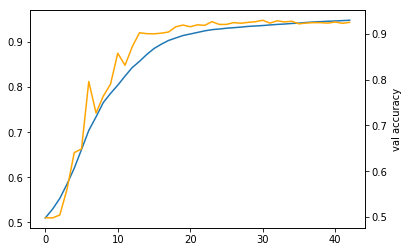

In [146]:
fig, ax1 = plt.subplots()
_ = ax1.plot(history.history['acc'])
ax2 = ax1.twinx()
_ = ax2.plot(history.history['val_acc'], c='orange')
ax2.set_ylabel('val accuracy')

In [151]:
targ_df = pd.DataFrame(targets, columns=targ_labels)

In [153]:
targets.shape

(12053, 230)

In [154]:
targ_df.shape

(12053, 230)

In [157]:
tot_0 = 0
tot_1 = 0
for c in targ_df.columns:
    vc = targ_df[c].value_counts()
    tot_0 += vc[0]
    tot_1 += vc[1]

In [158]:
tot_0/(tot_0 + tot_1)

0.9147399709255137

In [215]:
def get_no_info_rate(targets, targ_labels):
    targ_df = pd.DataFrame(targets, columns=targ_labels)
    tot_0 = 0
    tot_1 = 0
    for c in targ_df.columns:
        vc = targ_df[c].value_counts()
        tot_0 += vc[0]
        tot_1 += vc[1]
    
    if tot_0 > tot_1:
        print('no info rate:', str(tot_0 / (tot_0 + tot_1)))
    else:
        print('no info rate:', str(tot_1 / (tot_0 + tot_1)))

In [160]:
get_no_info_rate(targets, targ_labels)

no info rate: 0.9147399709255137


# set threshold to 1% -- need to reload data first

In [202]:
dfs, _, _ = dp.load_stocks(stocks=top_stocks,
                           finra_shorts=False,
                           short_interest=False,
                           earliest_date=None,
                           calc_scores=False)

loading stocks...
calculating TAs...


In [203]:
earliest_dfs = {s: dfs[s] for s in dfs.keys() if s in earliest_stocks}

In [204]:
for s in earliest_dfs.keys():
    # standardize to latest date so they all have the same earliest time
    earliest_dfs[s] = earliest_dfs[s][earliest_dfs[s].index > latest_date]

In [205]:
drop_cols(earliest_dfs)

In [206]:
make_ohlcv_feats_targs_multithread(earliest_dfs, threshold=0.01)

FL
HPQ
MRO
IP
BA
CAT
DIS
HON
UTX
GE
MRK
CVX
MCD
IBM
MO
XOM
MMM
KO
JNJ
PG
AEP
DTE
ED


In [207]:
feat_labels = []
targ_labels = []
features = None
for s in earliest_dfs.keys():
    targ_cols = [c for c in earliest_dfs[s].columns if 'f=' in c]
    feat_cols = [c for c in earliest_dfs[s].columns if c not in set(targ_cols)]
    no_missing = earliest_dfs[s].dropna()
    s_features = no_missing[feat_cols]
    feat_labels.extend([s + '_' + c for c in s_features.columns.tolist()])
    s_targets = no_missing[targ_cols]
    targ_labels.extend([s + '_' + c for c in s_targets.columns.tolist()])
    if features is None:
        features = s_features.values
        targets = s_targets.values
    else:
        features = np.hstack((features, s_features))
        targets = np.hstack((targets, s_targets))

train_size = int(features.shape[0] * train_frac)
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

In [208]:
targ_cols

['Adj_Close_pct_change_f=1_gt_0.01',
 'Adj_Close_pct_change_f=1_lt_-0.01',
 'Adj_Close_pct_change_f=2_gt_0.01',
 'Adj_Close_pct_change_f=2_lt_-0.01',
 'Adj_Close_pct_change_f=3_gt_0.01',
 'Adj_Close_pct_change_f=3_lt_-0.01',
 'Adj_Close_pct_change_f=4_gt_0.01',
 'Adj_Close_pct_change_f=4_lt_-0.01',
 'Adj_Close_pct_change_f=5_gt_0.01',
 'Adj_Close_pct_change_f=5_lt_-0.01',
 'Adj_Close_pct_change_f=6_gt_0.01',
 'Adj_Close_pct_change_f=6_lt_-0.01',
 'Adj_Close_pct_change_f=7_gt_0.01',
 'Adj_Close_pct_change_f=7_lt_-0.01',
 'Adj_Close_pct_change_f=8_gt_0.01',
 'Adj_Close_pct_change_f=8_lt_-0.01',
 'Adj_Close_pct_change_f=9_gt_0.01',
 'Adj_Close_pct_change_f=9_lt_-0.01',
 'Adj_Close_pct_change_f=10_gt_0.01',
 'Adj_Close_pct_change_f=10_lt_-0.01']

In [209]:
features.shape

(12053, 3381)

In [210]:
targets.shape

(12053, 460)

In [216]:
get_no_info_rate(targets, targ_labels)

no info rate: 0.6507537362157716


In [212]:
K.clear_session()

timesteps = 1
input_dim = train_features.shape[1]
output_dim = train_targets.shape[1]

inputs = Input(shape=(timesteps*input_dim, ))
x = BatchNormalization()(inputs)
x = Dense(3000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(2000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1000, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(500, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(output_dim, activation='sigmoid')(x)

mod = Model(inputs, x)
mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [213]:
es = EarlyStopping(monitor='val_loss', patience=50)

history = mod.fit(train_features,
            train_targets,
            epochs=300,
            validation_split=0.1,
            batch_size=2000,
            callbacks=[es])

Train on 8677 samples, validate on 965 samples
Epoch 1/300
8677/8677 [==============================] - 1s 156us/step - loss: 0.7726 - acc: 0.5136 - val_loss: 0.8262 - val_acc: 0.5093
Epoch 2/300
8677/8677 [==============================] - 1s 94us/step - loss: 0.6992 - acc: 0.5482 - val_loss: 0.8207 - val_acc: 0.5140
Epoch 3/300
8677/8677 [==============================] - 1s 96us/step - loss: 0.6766 - acc: 0.5759 - val_loss: 0.7769 - val_acc: 0.5197
Epoch 4/300
8677/8677 [==============================] - 1s 97us/step - loss: 0.6588 - acc: 0.6053 - val_loss: 0.7803 - val_acc: 0.5269
Epoch 5/300
8677/8677 [==============================] - 1s 96us/step - loss: 0.6423 - acc: 0.6295 - val_loss: 0.7703 - val_acc: 0.5365
Epoch 6/300
8677/8677 [==============================] - 1s 96us/step - loss: 0.6268 - acc: 0.6489 - val_loss: 0.8037 - val_acc: 0.5544
Epoch 7/300
8677/8677 [==============================] - 1s 97us/step - loss: 0.6111 - acc: 0.6674 - val_loss: 0.7692 - val_acc: 0.5707


8677/8677 [==============================] - 1s 91us/step - loss: 0.2853 - acc: 0.8731 - val_loss: 1.1320 - val_acc: 0.6184
Epoch 61/300
8677/8677 [==============================] - 1s 92us/step - loss: 0.2840 - acc: 0.8737 - val_loss: 1.1247 - val_acc: 0.6207
Epoch 62/300
8677/8677 [==============================] - 1s 91us/step - loss: 0.2817 - acc: 0.8748 - val_loss: 1.1331 - val_acc: 0.6169


Text(0,0.5,'val accuracy')

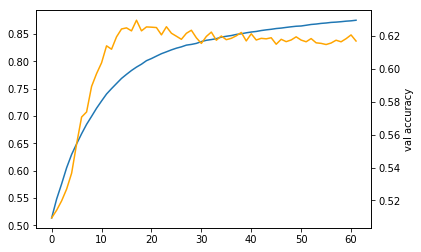

In [214]:
fig, ax1 = plt.subplots()
_ = ax1.plot(history.history['acc'])
ax2 = ax1.twinx()
_ = ax2.plot(history.history['val_acc'], c='orange')
ax2.set_ylabel('val accuracy')

In [217]:
mod.evaluate(train_features, train_targets)

9642/9642 [==============================] - 1s 127us/step


[0.3411893638627852, 0.8618561902424033]

In [218]:
mod.evaluate(test_features, test_targets)

2411/2411 [==============================] - 0s 123us/step


[1.4007189850844768, 0.5969388476796588]

In [230]:
train_preds = mod.predict(train_features)
test_preds = mod.predict(test_features)

In [221]:
from sklearn.metrics import roc_curve, auc

In [222]:
targ_labels

['FL_Adj_Close_pct_change_f=1_gt_0.01',
 'FL_Adj_Close_pct_change_f=1_lt_-0.01',
 'FL_Adj_Close_pct_change_f=2_gt_0.01',
 'FL_Adj_Close_pct_change_f=2_lt_-0.01',
 'FL_Adj_Close_pct_change_f=3_gt_0.01',
 'FL_Adj_Close_pct_change_f=3_lt_-0.01',
 'FL_Adj_Close_pct_change_f=4_gt_0.01',
 'FL_Adj_Close_pct_change_f=4_lt_-0.01',
 'FL_Adj_Close_pct_change_f=5_gt_0.01',
 'FL_Adj_Close_pct_change_f=5_lt_-0.01',
 'FL_Adj_Close_pct_change_f=6_gt_0.01',
 'FL_Adj_Close_pct_change_f=6_lt_-0.01',
 'FL_Adj_Close_pct_change_f=7_gt_0.01',
 'FL_Adj_Close_pct_change_f=7_lt_-0.01',
 'FL_Adj_Close_pct_change_f=8_gt_0.01',
 'FL_Adj_Close_pct_change_f=8_lt_-0.01',
 'FL_Adj_Close_pct_change_f=9_gt_0.01',
 'FL_Adj_Close_pct_change_f=9_lt_-0.01',
 'FL_Adj_Close_pct_change_f=10_gt_0.01',
 'FL_Adj_Close_pct_change_f=10_lt_-0.01',
 'HPQ_Adj_Close_pct_change_f=1_gt_0.01',
 'HPQ_Adj_Close_pct_change_f=1_lt_-0.01',
 'HPQ_Adj_Close_pct_change_f=2_gt_0.01',
 'HPQ_Adj_Close_pct_change_f=2_lt_-0.01',
 'HPQ_Adj_Close_pct_ch

0.9192373006430897


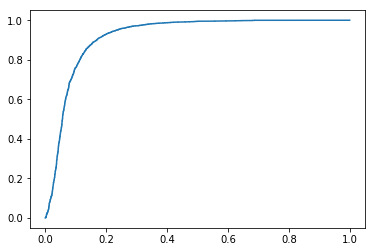

In [228]:
fpr, tpr, _ = roc_curve(train_targets[:, 8], train_preds[:, 8])
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

0.5353220564952921


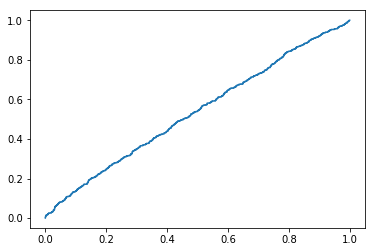

In [231]:
fpr, tpr, _ = roc_curve(test_targets[:, 8], test_preds[:, 8])
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

# maybe just not enough samples for neural nets, try other ML methods

In [119]:
from sklearn.svm import SVC

In [120]:
clf = SVC()

In [121]:
clf.fit(train_features, train_targets[:, 4])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [122]:
clf.score(train_features, train_targets[:, 4])

1.0

In [123]:
clf.score(test_features, test_targets[:, 4])

0.8747407714641228

In [124]:
test_features.shape

(2411, 147)

In [125]:
clf.score(test_features[:500], test_targets[:500, 4])

0.768

In [126]:
clf.score(test_features[500:], test_targets[500:, 4])

0.902668759811617